<a href="https://colab.research.google.com/github/GitMarco27/TMML/blob/main/Notebooks/011_Dtw_Loss_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Minutes Machine Learning
## Episode 11: Dtw Loss Function

#### Marco Sanguineti, 2021
---
Welcome to 3 minutes Machine Learning!

Tested on PC win1064-1036593 tf262 (note this is the lower case version!!)
18th August 2023

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

C:\Users\rbj\AppData\Local\Temp\ipykernel_11064\1158607906.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.6.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import os
def loadThumb(path):
  # Let's import this video thumbnail!
  if os.path.exists(path):
    myThumb = plt.imread(path)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.axis('off')
    ax.imshow(myThumb)
    plt.show()

loadThumb('yt_thumb_011.png')
#It didn't exist... not needed!!


## Creating DTW Loss Function


---
This works nicely


In [4]:
class DtwLoss(tf.keras.losses.Loss):
    def __init__(self, batch_size: int = 32):
        super(DtwLoss, self).__init__()
        self.batch_size = batch_size

    def call(self, y_true, y_pred):
        tmp = []
        for item in range(self.batch_size):
            #tf.print(f'Working on batch: {item}\n')
            s = y_true[item, :]
            t = y_pred[item, :]
            n, m = len(s), len(t)
            dtw_matrix = []
            for i in range(n + 1):
                line = []
                for j in range(m + 1):
                    if i == 0 and j == 0:
                        line.append(0)
                    else:
                        line.append(np.inf)
                dtw_matrix.append(line)

            for i in range(1, n + 1):
                for j in range(1, m + 1):
                    cost = tf.abs(s[i - 1] - t[j - 1])
                    last_min = tf.reduce_min([dtw_matrix[i - 1][j], dtw_matrix[i][j - 1], dtw_matrix[i - 1][j - 1]])
                    dtw_matrix[i][j] = tf.cast(cost, dtype=tf.float32) + tf.cast(last_min, dtype=tf.float32)

            temp = []
            for i in range(len(dtw_matrix)):
                temp.append(tf.stack(dtw_matrix[i]))

            tmp.append(tf.stack(temp)[n, m])
        return tf.reduce_mean(tmp)

In [5]:
n=50
batch_size=10
noise_amplitude = 0.1  # Adjust the amplitude of the noise

xs=[]
for i in range(batch_size):
    temp=np.cos(np.linspace(0, 360,num=n)*3.14/180)
    # Add noise to the sine wave            
    random_noise = np.random.normal(0, noise_amplitude, n)       
    xs.append(temp + random_noise)
    
np.asarray(xs).shape


(10, 50)

Create a couple of curves as actual tensors

In [6]:
#x = tf.Variable(np.cos(np.linspace(0, n)*3.14/180).reshape(1, -1))
#have made a load of them now
x = tf.Variable(np.asarray(xs).reshape(batch_size,-1))
y = tf.Variable(np.sin(np.linspace(0, 360)*3.14/180).reshape(1, -1))

For a look-see, convery back to numpy and plot'em

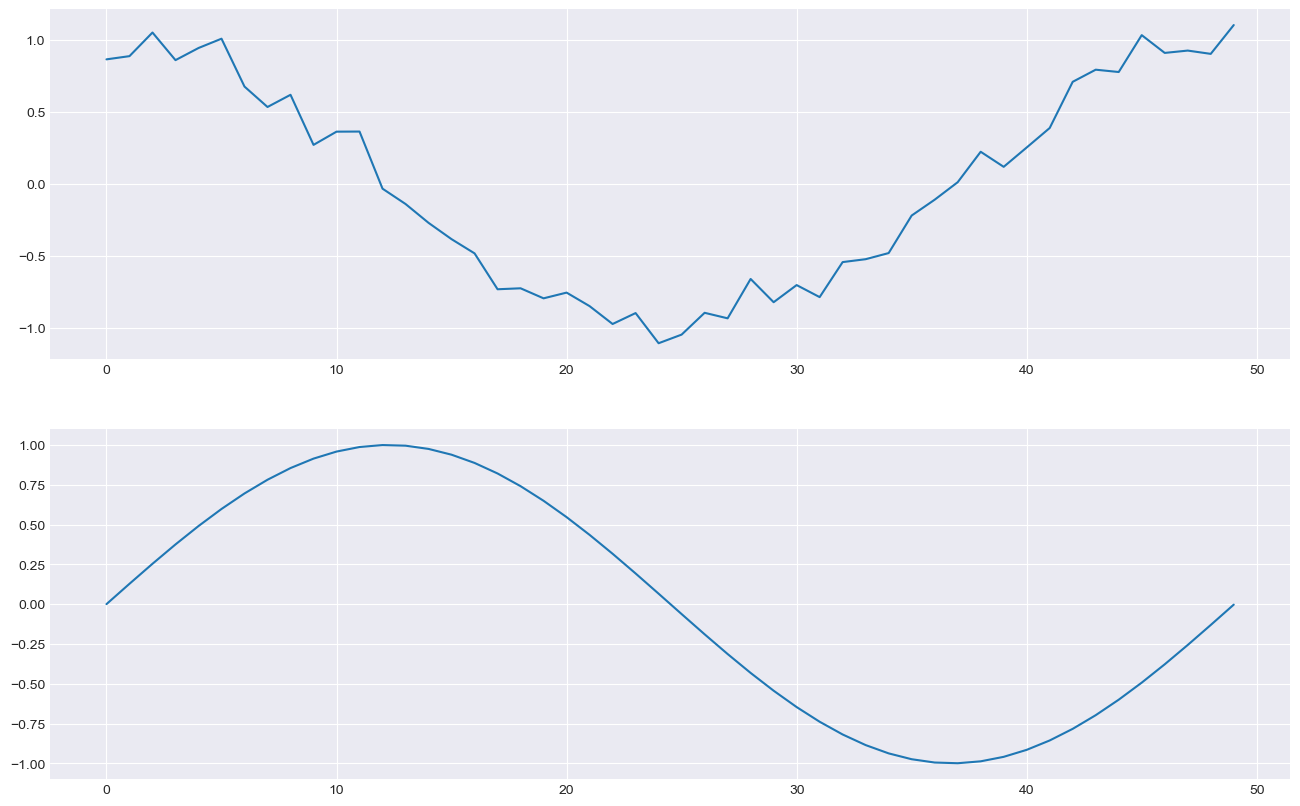

In [7]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 10))
#just plot the first x!
axs[0].plot(x.numpy()[0].reshape(-1))
axs[1].plot(y.numpy().reshape(-1))
plt.show()

In [8]:
print(y.shape)
print(x[0,:].shape)

(1, 50)
(50,)


Create the loss class
and just see if it works by calling with x as the data and y as the prediction

In [9]:
loss = DtwLoss(batch_size=1)
print(f'Loss value: {loss(tf.reshape(x[0,:],shape=y.shape),y).numpy()}')

Working on batch: 0

Loss value: 14.487508773803711


So it works and returns a suitable value; of course converted to a regular variable to print.

## Basic Stacked Autoencoder Implementation


---
A simple (encoder) NN model with just one layer and 10 fully connected neurones

In [10]:
# Encoder
input = tf.keras.layers.Input(shape=(x.shape[1]))
dense_1 = tf.keras.layers.Dense(10, activation='relu')(input)
encoder = tf.keras.models.Model(inputs=input, outputs=dense_1)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 510
Trainable params: 510
Non-trainable params: 0
_________________________________________________________________


...and a matching decoder....

In [11]:
# Decoder
input = tf.keras.layers.Input(shape=(10))
dense_1 = tf.keras.layers.Dense(x.shape[1], activation='linear')(input)
decoder = tf.keras.models.Model(inputs=input, outputs=dense_1)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                550       
Total params: 550
Trainable params: 550
Non-trainable params: 0
_________________________________________________________________


In [12]:
# AE
model = tf.keras.models.Sequential([
                                    encoder,
                                    decoder
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 10)                510       
_________________________________________________________________
model_1 (Functional)         (None, 50)                550       
Total params: 1,060
Trainable params: 1,060
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [14]:
history = model.fit(x.numpy(), x.numpy(), epochs=10)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5784
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.5664
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.5553
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.5450
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.5353
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 0.5262
Epoch 7/10
1/1 [==============================] - 0s 12ms/step - loss: 0.5177
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.5095
Epoch 9/10
1/1 [==============================] - 0s 51ms/step - loss: 0.5017
Epoch 10/10
1/1 [==============================] - 0s 8ms/step - loss: 0.4942


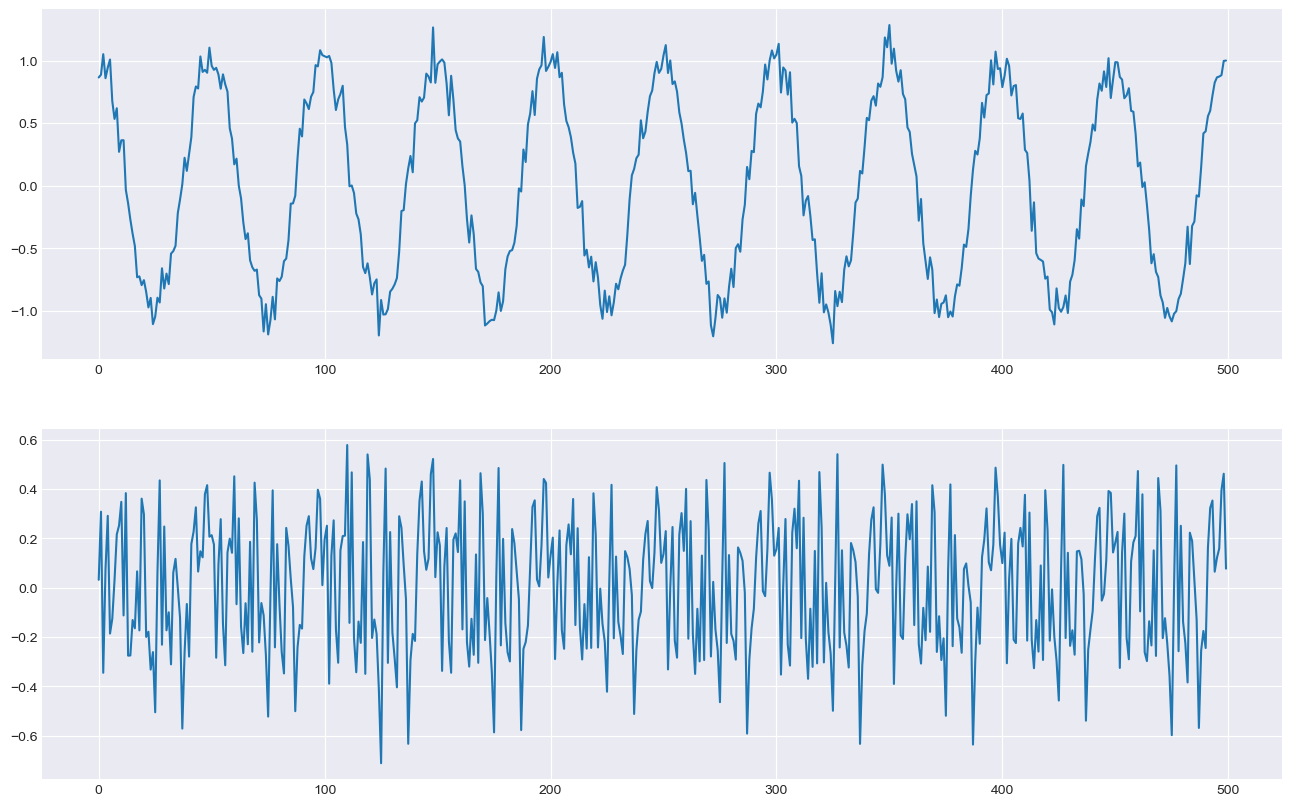

In [15]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 10))
axs[0].plot(x.numpy().reshape(-1))
axs[1].plot(model(x.numpy()).numpy().reshape(-1))
plt.show()

In [19]:
model.save_weights('model.h5')

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=DtwLoss(batch_size=batch_size))

In [21]:
model.load_weights('model.h5')

In [22]:
history2=model.fit(x.numpy(), x.numpy(), epochs=10)

Epoch 1/10
Working on batch: 0

Working on batch: 1

Working on batch: 2

Working on batch: 3

Working on batch: 4

Working on batch: 5

Working on batch: 6

Working on batch: 7

Working on batch: 8

Working on batch: 9

1/1 [==============================] - 5476s 5476s/step - loss: 21.8672
Epoch 2/10
Working on batch: 0

Working on batch: 1

Working on batch: 2

Working on batch: 3

Working on batch: 4

Working on batch: 5

Working on batch: 6

Working on batch: 7

Working on batch: 8

Working on batch: 9

1/1 [==============================] - 13s 13s/step - loss: 21.2575
Epoch 3/10
Working on batch: 0

Working on batch: 1

Working on batch: 2

Working on batch: 3

Working on batch: 4

Working on batch: 5

Working on batch: 6

Working on batch: 7

Working on batch: 8

Working on batch: 9

1/1 [==============================] - 15s 15s/step - loss: 20.7069
Epoch 4/10
Working on batch: 0

Working on batch: 1

Working on batch: 2

Working on batch: 3

Working on batch: 4

Working on ba

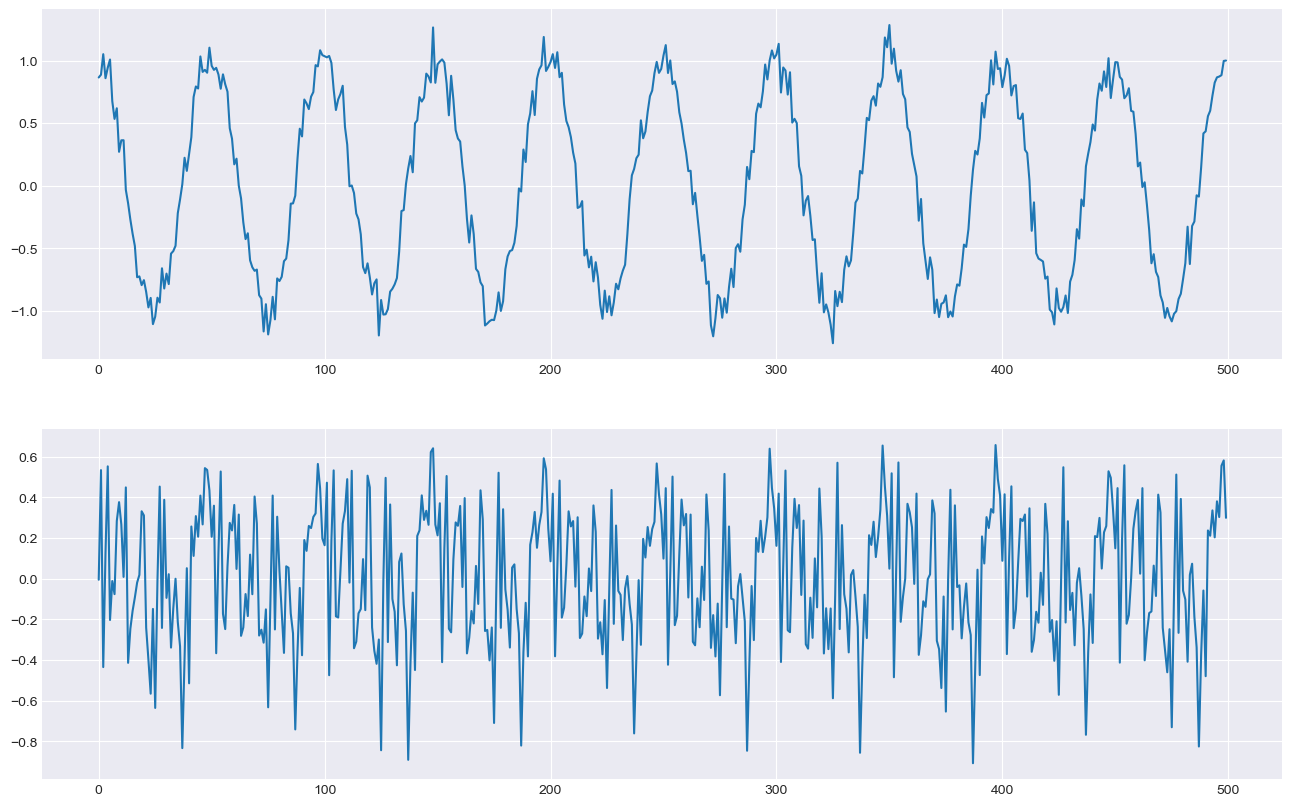

In [23]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 10))
axs[0].plot(x.numpy().reshape(-1))
axs[1].plot(model(x.numpy()).numpy().reshape(-1))
plt.show()

OK doesn't work at all, I presume because we have only one file. I thought it would just overfit it? Given enough itterations.  Try again with 1000x the itterations...